# Library Setup

In [ ]:
!pip install pandasql
!pip install deep-translator
!pip install matplotlib --upgrade

In [ ]:
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
from collections import Counter
from deep_translator import GoogleTranslator
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Data Loading
Here we directly download dataset from Kaggle

Kaggle dataset page: https://www.kaggle.com/datasets/openfoodfacts/world-food-facts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!!kaggle datasets download -d openfoodfacts/world-food-facts
!unzip /content/world-food-facts.zip
df_food = pd.read_csv("/content/en.openfoodfacts.org.products.tsv", sep='\t')

Let us take a quick look at the dataset

In [ ]:
df_food.head(10)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,16100,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,16117,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,16124,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN
8,16193,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,16513,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055654,2017-03-09T10:34:14Z,1489055654,2017-03-09T10:34:14Z,Organic Sunflower Oil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking the null value in each column

In [ ]:
df_null_percentage = df_food.isna().sum() / len(df_food) * 100
display(HTML(df_null_percentage.to_frame().to_html()))

,0
code,0.007303
url,0.007303
creator,0.000843
created_t,0.000843
created_datetime,0.002809
last_modified_t,0.000000
last_modified_datetime,0.000000
product_name,4.918728
generic_name,83.789432
quantity,66.495519


# Data Preprocessing

We notice that the dataset contains large number of missing data. Therefore,
Imputation is of great importance in data preprocessing.

## Fully Missing Columns
From *df_null_percentage*, we see there are some columns that have 100% missing percentage. Here we drop them out first.

Since column *ph_100g* has a missing rate of 99.98% and its measurement is quite
different, we decide to drop *ph_100g*.

In [ ]:
# drop list: to record the column name of whom has 100% missing percentage.
drop_list = []
for i, j in df_null_percentage.iteritems():
  if j == 100.0:
    drop_list.append(i)

drop_list
df_food_clean = df_food.drop(columns=drop_list)

# drop pH column
df_food_clean = df_food_clean.drop(columns=['ph_100g'])

## Data Imputation

From column indexed 59 to the end, we are filling missing data with 0, i.e., we are imputing all quantizable nutrient data.

In [ ]:
df_food_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 146 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    code                                        object 
 1    url                                         object 
 2    creator                                     object 
 3    created_t                                   object 
 4    created_datetime                            object 
 5    last_modified_t                             object 
 6    last_modified_datetime                      object 
 7    product_name                                object 
 8    generic_name                                object 
 9    quantity                                    object 
 10   packaging                                   object 
 11   packaging_tags                              object 
 12   brands                                      object 
 13   brands_tags 

In [ ]:
# Create filling dict: only fill columns that indexed from 59 to 144
#
list_to_fill = df_food_clean.columns[59:144]
fill_dict = dict.fromkeys(list_to_fill, 0.0)

# imputing
df_food_clean = df_food_clean.fillna(fill_dict)

In [ ]:
# check if the columns we want are imputed
df_null_percentage = df_food_clean.isna().sum() / len(df_food_clean) * 100
display(HTML(df_null_percentage.to_frame().to_html()))

,0
code,0.007303
url,0.007303
creator,0.000843
created_t,0.000843
created_datetime,0.002809
last_modified_t,0.000000
last_modified_datetime,0.000000
product_name,4.918728
generic_name,83.789432
quantity,66.495519


## Dropping irrelavant rows

We don't want products that has no code. Otherwise, it is hard to identify them in future EDA & modelling

In [ ]:
df_food_clean = df_food_clean.dropna(subset = ['code'])

We are going to study how nutrient effects nutrition score, We can't really fill those rows that has no nutrition score since nutrition score will be labels in our future modeling. Here, we simply drop them.

Noticed that *nutrition-score-fr_100g* and *nutrition-score-uk_100g* have the same missing rates. It is likely that the missing rows of this two columns are identical. If that is the case, we could use one Dataframe after removing NaN rows. Here we give a quick check about how the cleaned dataset differs.

In [ ]:
# Only drop null rows in 'nutrition-score-fr_100g'
df_food_clean_1 = df_food_clean.dropna(subset = ['nutrition-score-fr_100g'])
# Only drop null rows in 'nutrition-score-uk_100g'
df_food_clean_2 = df_food_clean.dropna(subset = ['nutrition-score-uk_100g'])

In [ ]:
df_null_percentage_1 = df_food_clean_1.isna().sum() / len(df_food_clean_1) * 100
df_null_percentage_2 = df_food_clean_2.isna().sum() / len(df_food_clean_1) * 100
print(df_null_percentage_1['nutrition-score-fr_100g'])
print(df_null_percentage_1['nutrition-score-uk_100g'])
print(df_null_percentage_2['nutrition-score-fr_100g'])
print(df_null_percentage_2['nutrition-score-uk_100g'])

0.0
0.0
0.0
0.0


As shown above, dropping either of the two columns would cause another column 0 missing rate. Therefore, it is safe to use either *df_food_clean_1* or *df_food_clean_2*. Here we use *df_food_clean_1* for future EDA and modelling

In [ ]:
df_food_clean = df_food_clean_1.drop_duplicates()

# EDA

## Nutrition Score Analysis


### How these two rating system different?
We are curious about the differece between France score and UK score. Therefore, as a first step, we select best 10 food in France and UK to see how they are different.

In [ ]:
df_product_score = df_food_clean[['product_name', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']]

# sort by France score
df_product_score.sort_values(by=['nutrition-score-fr_100g', 'product_name'], ascending=[False, True]).head(10)

,product_name,nutrition-score-fr_100g,nutrition-score-uk_100g
56218,Cafe Collection Coffee & Milk Creamer,40.0,40.0
56245,Coffee & Milk Creamer,40.0,40.0
190681,Granulowany napój herbaciany,40.0,29.0
56217,"Maxwell House, Creme Cappuccino",40.0,40.0
56328,"Tim Hortons, Cafe & Bake Shop Latte",38.0,38.0
274243,Bouchees Coco Choc Lait,37.0,37.0
56312,Cappuccino,37.0,37.0
264659,Cappuccino Classique,37.0,31.0
56221,Cappuccino Decaffeinated,37.0,37.0
116398,Barre Chocolatée Au Lait Hershey's,36.0,36.0


In [ ]:
# sort by UK score
df_product_score.sort_values(by=['nutrition-score-uk_100g', 'product_name'], ascending=[False, True]).head(10)

,product_name,nutrition-score-fr_100g,nutrition-score-uk_100g
56218,Cafe Collection Coffee & Milk Creamer,40.0,40.0
56245,Coffee & Milk Creamer,40.0,40.0
56217,"Maxwell House, Creme Cappuccino",40.0,40.0
56328,"Tim Hortons, Cafe & Bake Shop Latte",38.0,38.0
274243,Bouchees Coco Choc Lait,37.0,37.0
56312,Cappuccino,37.0,37.0
56221,Cappuccino Decaffeinated,37.0,37.0
116398,Barre Chocolatée Au Lait Hershey's,36.0,36.0
274244,Bouchees Coco Choc Noir,36.0,36.0
111950,"Cafe Escapes, Coffee, Cafe Vanilla",36.0,36.0


Seen from the sorting results, the two evaluation system does not quite differ from each other in food with high scores, except that there are some divergence when sorting by France score.

However, much to our surprise, coffee takes over 50% positions of the top 10 list under both evaluation system. Does this mean coffee is inherently better than other products?

After some investigation, we found that these coffee products, without exception, are powders, which means that they are concentrated during producing process and should be brewed with hot water when using. Since the score is still based on nutrient facts, this will not make data biaed or affect our model.

### How does different brands perform in nutrient scoring
Let's look into how UK and France satisfies with different brand.

We notice the fact that there are quite a few brands that have only one products. To averaging them makes little sense. Since there are ~250,000 product entries with ~48,000 brands, we decide to look into these big names' performance

In [ ]:
df_brand_score = df_food_clean[['brands', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']]
df_brand_score['brands'].unique().shape

(47790,)

In [ ]:
# For each brand, we count its entry number
df_brand_score['count'] = df_brand_score.groupby('brands')['brands'].transform('count')
df_brand_score = df_brand_score.dropna()

# truncate the dataframe: we only want brands that has more than 20 products.
df_brand_score_trunc = df_brand_score[df_brand_score['count'] > 20]

df_list = df_brand_score_trunc.groupby('brands').mean().sort_values(by='nutrition-score-uk_100g', ascending=False)

<ipython-input-17-f98da2e3ec63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brand_score['count'] = df_brand_score.groupby('brands')['brands'].transform('count')


In [ ]:
df_list.head(10)

,nutrition-score-fr_100g,nutrition-score-uk_100g,count
brands,,,
Schogetten,26.857143,26.857143,21.0
Gavottes,26.708333,26.708333,24.0
"Kinder,Ferrero",26.631579,26.631579,57.0
Ritter Sport,26.109375,26.109375,64.0
Kinder,26.102273,26.102273,88.0
Fancypants Baking Co.,25.818182,25.818182,22.0
Lindt,25.408488,25.408488,377.0
"Lindt,Lindt & Sprüngli",25.291667,25.291667,24.0
Twix,25.206897,25.206897,29.0


The interesting thing about the top 10 list of branches is that, different from coffee dominance we saw just now, this time the brands that produce chocolate & chocolate like candies have take almost all the position.

In [ ]:
df_list.tail(10)

,nutrition-score-fr_100g,nutrition-score-uk_100g,count
brands,,,
Mueller's,-5.266667,-5.266667,45.0
New World Pasta Company,-5.318182,-5.318182,22.0
Montebello,-5.655172,-5.655172,29.0
"Saint Eloi,Sélection des Mousquetaires,Les Mousquetaires",-5.681818,-5.681818,22.0
"Ronzoni, New World Pasta Company",-5.936508,-5.936508,63.0
"San Giorgio, New World Pasta Company",-6.000000,-6.000000,41.0
"Prince, New World Pasta Company",-6.000000,-6.000000,24.0
"Creamette, Nwpc",-6.034483,-6.034483,29.0
"Creamette, New World Pasta Company",-6.076923,-6.076923,26.0


From this top 10 unsatisfied list, we keep seeing company name 'New World Pasta Company'. Seems like its product performed badly in terms of getting nutrient scores.

### Nutritious food: what is good in it?

The previous two EDAs give us some insight into product/company's performance in scoring. We found that the evaluation system seems quite in favor of coffee and chocolate. Let's try to look into the food nutrition structure of coffee and chocolate. This might give us some hint on what nutrient contribute more to the score.

For coffee, let's simply grab the product that scores 40 (i.e. the best).

---



In [ ]:
best_food_name = df_product_score[(df_product_score['nutrition-score-fr_100g']==40) & (df_product_score['nutrition-score-uk_100g']==40)]['product_name']
coffee = df_food_clean[df_food_clean['product_name'].isin(best_food_name)]

# retrieve all nutrients that are not zero
nutrient_coffee = coffee[list_to_fill]
nutrient_coffee = nutrient_coffee[nutrient_coffee[list_to_fill] != 0].dropna(axis=1)
nutrient_coffee.insert(loc=0,column='product_name',value=best_food_name)
nutrient_coffee

,product_name,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g
56217,"Maxwell House, Creme Cappuccino",4184.0,56.25,37.50,0.188,75.00,75.00,37.50,3.33248,1.312,1.000
56218,Cafe Collection Coffee & Milk Creamer,4707.0,75.00,43.75,0.250,87.50,75.00,50.00,3.96748,1.562,1.250
56245,Coffee & Milk Creamer,5577.0,100.00,58.33,0.333,66.67,66.67,66.67,6.35000,2.500,1.667


For chocolate, we select the one of the brand Schogetten that has the highest score

In [ ]:
chocolate = df_food_clean[df_food_clean['brands'] == 'Schogetten'][['product_name', 'nutrition-score-fr_100g']]
chocolate = chocolate.sort_values(by='nutrition-score-fr_100g', ascending=False).head(1)
chocolate

,product_name,nutrition-score-fr_100g
279912,Vanille-Waffel,28.0


In [ ]:
waffel = df_food_clean[df_food_clean['product_name'] == 'Vanille-Waffel']

waffel = waffel[list_to_fill]
waffel = waffel[waffel[list_to_fill] != 0].dropna(axis=1)
waffel.insert(0,'product_name','Vanille-Waffel')
waffel

,product_name,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,cocoa_100g
279912,Vanille-Waffel,2380.0,37.0,20.0,54.0,53.0,5.0,0.23,0.090551,30.0


These relatively high scored products give us some insight about how a high score food's nutrient structure should look like: ususlly it contains some of the most familiar names: fat, cholesterol, carbohydrates, sugars, peroteins, salt and so on.

## Ingredients Analysis

We'd like to count occurrences of each ingredient to create food ingredient preference profiles for each country and each brand and compare the difference between countries and brands.

### Ingredient preference profiles for each country



In [ ]:
df_food_clean.groupby('countries_en').count().reset_index().sort_values('code',ascending=False).head()

,countries_en,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,...,iodine_100g,caffeine_100g,taurine_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
552,United States,139076,139076,139076,139076,139076,139076,139076,138984,401,...,139076,139076,139076,139076,139076,139076,139076,139076,139076,139076
279,France,89045,89045,89044,89045,89045,89045,89045,88702,30930,...,89045,89045,89045,89045,89045,89045,89045,89045,89045,89045
536,Switzerland,8865,8865,8865,8865,8865,8865,8865,6967,630,...,8865,8865,8865,8865,8865,8865,8865,8865,8865,8865
411,Germany,4813,4813,4813,4813,4813,4813,4813,4630,3503,...,4813,4813,4813,4813,4813,4813,4813,4813,4813,4813
525,Spain,2564,2564,2564,2564,2564,2564,2564,2542,2422,...,2564,2564,2564,2564,2564,2564,2564,2564,2564,2564


Since the number of products in United States and France are much larger than the rest. We will focus on these two countries for the country ingredient preference.

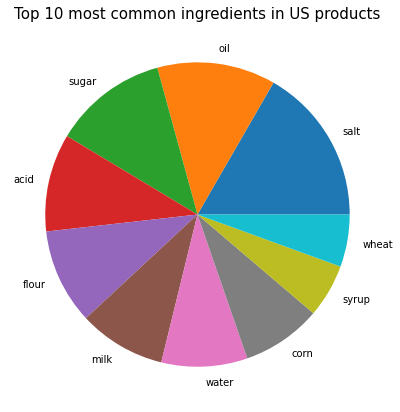

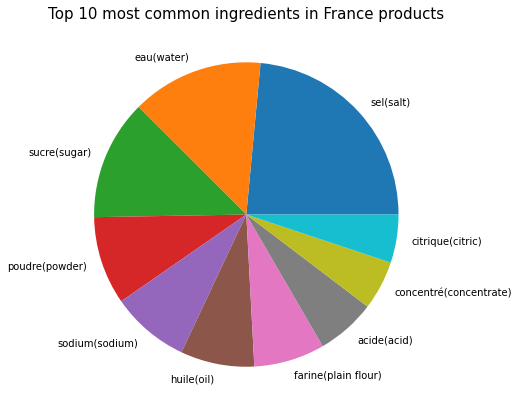

In [ ]:
def tokenize_content(content,stopw):
  result = []
  words = nltk.word_tokenize(content)
  words_tag = nltk.pos_tag(words)
  nnwords = []
  for i in words_tag:
    if (i[1] == 'NN') & (i[0].isalpha()): # identify all the alpha nonu words
      nnwords.append(i[0].lower())
  for i in nnwords:
    temp = ''
    if i not in stopw:
      temp = temp + i
    result.append(temp)

  return list(filter(None,result))

def most_common10(ing_list,stopw):
  result = []
  for i in ing_list:
    for j in tokenize_content(str(i),stopw):
      result.append(j)

  return Counter(result).most_common(10)
df_foodprofiles = df_food_clean[['countries_en','ingredients_text']]
# Top 10 most common ingredients in US products
using_list = df_foodprofiles[df_foodprofiles['countries_en']=='United States']['ingredients_text'].tolist()
stopw = set(nltk.corpus.stopwords.words('english')+['nan'])
usprofile = most_common10(using_list,stopw)

# Top 10 most common ingredients in France products
fring_list = df_foodprofiles[df_foodprofiles['countries_en']=='France']['ingredients_text'].tolist()
stopw = set(nltk.corpus.stopwords.words('french')+['nan'])
frprofile = most_common10(fring_list,stopw)

# Let's visualize it with pie graph
using_product = list(list(zip(*usprofile))[0])
using_data = list(list(zip(*usprofile))[1])
fring_product = list(list(zip(*frprofile))[0])
fring_product_tran = [i+'('+GoogleTranslator(source='french', target='english').translate(i)+')' for i in fring_product]
fring_data = list(list(zip(*frprofile))[1])
fig = plt.figure(figsize=(10,7))
plt.pie(using_data, labels = using_product)
plt.title('Top 10 most common ingredients in US products',fontsize=15)
plt.show()
fig = plt.figure(figsize=(10,7))
plt.pie(fring_data, labels = fring_product_tran)
plt.title('Top 10 most common ingredients in France products',fontsize=15)
plt.show()

### Ingredient preference profiles for each brand in US and France

In [ ]:
usfrfood_df = df_food_clean[(df_food_clean['countries_en']=='France')|(df_food_clean['countries_en']=='United States')]
usfrfood_brand_df = usfrfood_df.groupby('brands').count().reset_index().sort_values('code',ascending=False)
usfrfood_brand_df.head()

,brands,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,...,iodine_100g,caffeine_100g,taurine_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
5909,Carrefour,2917,2917,2917,2917,2917,2917,2917,2915,1323,...,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917
1956,Auchan,2766,2766,2766,2766,2766,2766,2766,2761,840,...,2766,2766,2766,2766,2766,2766,2766,2766,2766,2766
38710,U,2279,2279,2279,2279,2279,2279,2279,2276,1155,...,2279,2279,2279,2279,2279,2279,2279,2279,2279,2279
6143,Casino,1801,1801,1801,1801,1801,1801,1801,1797,594,...,1801,1801,1801,1801,1801,1801,1801,1801,1801,1801
21145,Leader Price,1680,1680,1680,1680,1680,1680,1680,1676,858,...,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680


Since the difference between different brands is relatively small, we decide to choose brands that have more than 500 products in the dataset.

In [ ]:
brandname = usfrfood_brand_df[usfrfood_brand_df['code']>500]['brands'].tolist()
branding = []
for i in range(len(brandname)):
  branding.append(usfrfood_df[usfrfood_df['brands']==brandname[i]]['ingredients_text'].tolist())
stopw = set(nltk.corpus.stopwords.words('french')+nltk.corpus.stopwords.words('english')+['nan'])
result = []
for i in range(len(branding)):
  result.append(most_common10(branding[i],stopw))

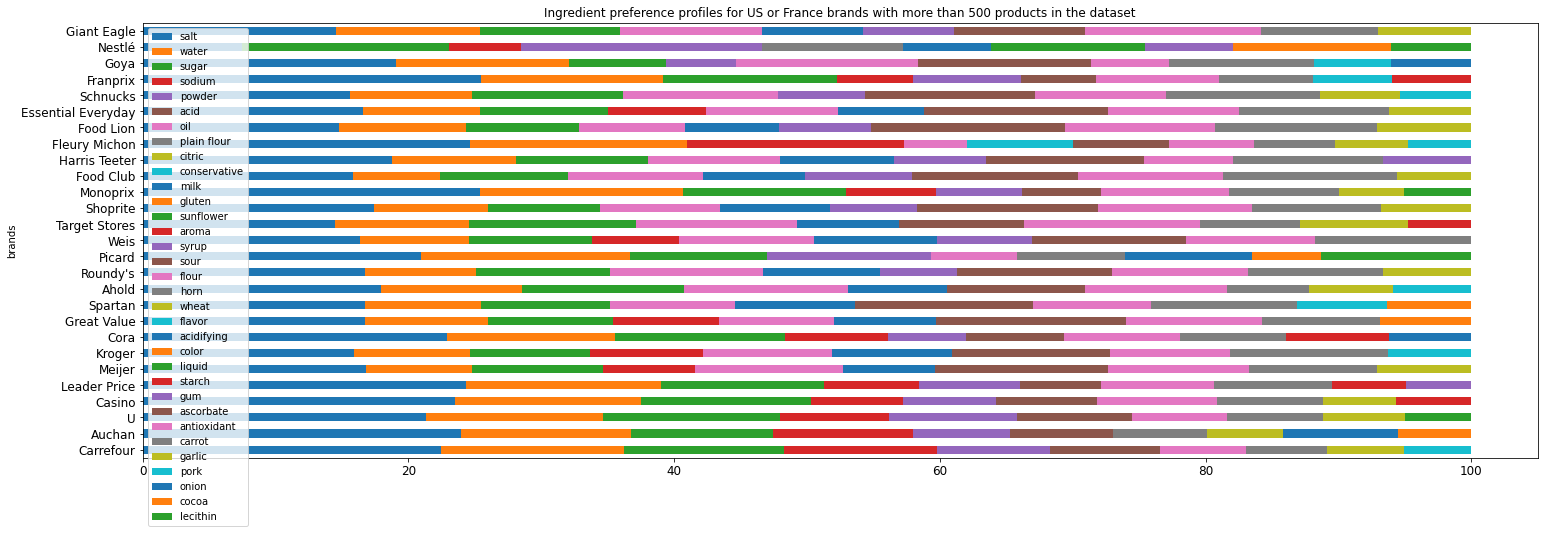

In [ ]:
# Translate French to English
result_tran = []
for i in range(len(result)):
  temp = list(list(zip(*result[i]))[0])
  temp_dict = dict(result[i])
  for j in range(len(temp)):
    temp_dict[GoogleTranslator(source='french', target='english').translate(temp[j])] = temp_dict.pop(temp[j])
  result_tran.append(list(temp_dict.items()))

# Visualize result_tran using stacked horizonal bar plot
brand_result_df = pd.DataFrame(dict(result_tran[0]),index=[brandname[0]])
for i in range(1,len(result_tran)):
  df = pd.DataFrame(dict(result_tran[i]),index=[brandname[i]])
  brand_result_df = pd.concat([brand_result_df,df],axis=0)
brand_result_df = brand_result_df.fillna(0)
brand_result_df = brand_result_df.div(brand_result_df.sum(axis=1), axis=0).mul(100).round(3)
brand_result_df = brand_result_df.reset_index()
brand_result_df = brand_result_df.rename(columns={'index':'brands'})
brand_result_df.plot(x = 'brands', fontsize=12, kind='barh', stacked=True, figsize = (25,8), title='Ingredient preference profiles for US or France brands with more than 500 products in the dataset')
plt.legend(brand_result_df.columns.tolist()[1:],prop={'size':10},loc=2)
plt.show()

## Additive Analysis

Food additive has been a lingering and controversial topic. From perspective of food scores in France and UK, let's dig into it.

### Food additive number distribution

As a first step, let's find out the distribution of how many additive each product uses.

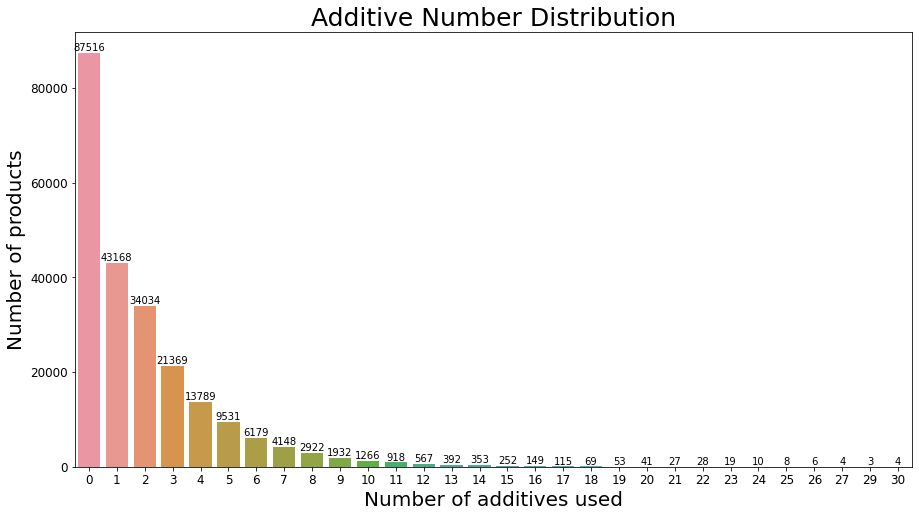

In [ ]:
df_score_additive = df_food_clean[['product_name', 'additives_n', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']]

# gather by additive number
additive_count = df_score_additive.groupby(by='additives_n').count().reset_index()
additive_count['additives_n'] = additive_count['additives_n'].apply(lambda x: round(x))
plt.figure(figsize=(15,8))
ax = sns.barplot(data=additive_count, x="additives_n", y="product_name")
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of additives used', fontsize=20)
ax.set_ylabel('Number of products', fontsize=20)
ax.axes.set_title("Additive Number Distribution", fontsize=25)
ax.tick_params(labelsize=12)

The trend is quite clear in the plot: as additive number increases, the number of products decreases. There are approximately one third of the products that do not use additives. We still observed some extreme data points: there are about 25 kinds of product that uses more than 25 kinds of additives.

### Will Additives Affect Food Score?

Based on the previous results, we could go a step further: By computing the average food nutrient score under different number of used additive, we could get to know whether using additive will influence nutrient score or not.

Text(0.5, 1.0, 'Average Nutrient Score - Additive Number')

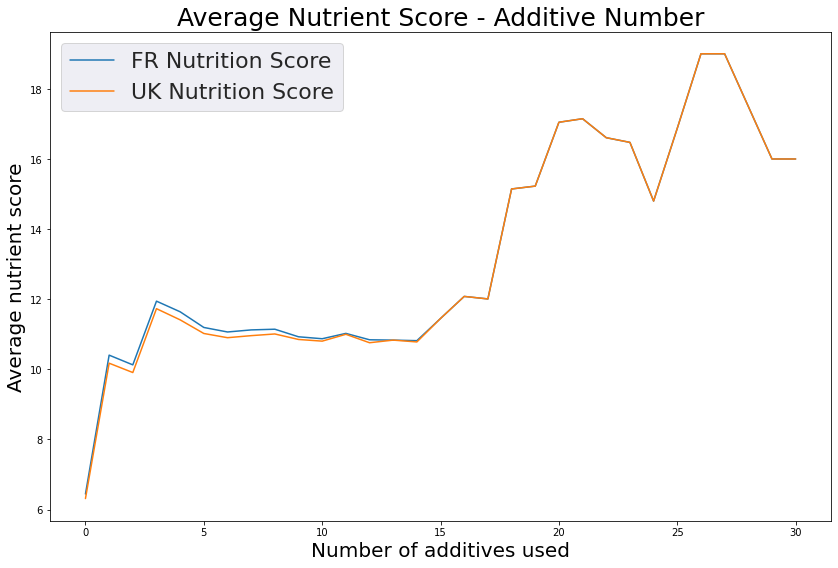

In [ ]:
df_additive_mean = df_score_additive.groupby(by='additives_n').agg('mean').reset_index()
df_additive_mean['additives_n'] = df_additive_mean['additives_n'].apply(lambda x: round(x))

fig, ax = plt.subplots(figsize=(14, 9))
sns.set(font_scale=2)
sns.lineplot(data = df_additive_mean, x = "additives_n", label = 'FR Nutrition Score', y = 'nutrition-score-fr_100g', ci = None)
sns.lineplot(data = df_additive_mean, x = "additives_n", label = 'UK Nutrition Score', y = 'nutrition-score-uk_100g', ci = None)
ax.set_xlabel('Number of additives used', fontsize=20)
ax.set_ylabel('Average nutrient score', fontsize=20)
ax.axes.set_title("Average Nutrient Score - Additive Number", fontsize=25)

The trend is not as clear as previous section shows. We could still say that as the number of additives increases, the average score increases. But the increasing is not monotonic, with some fluctuation observed. Under these two evaluation system, additive is not something harmful: food uses a lot of additives is still likely to get a high score.

Another thing is that there is some little divergence between UK and France evaluation system. UK scoring is a little bit lower than France when additive number is between 2 and 14, which implies that UK is more strict towards additive using.

## Nutrient Analysis
Next we will further explore the relationship between nutrients and nutrition scores. Since there are a lot of categories, we divided them into multiple correlation matrix.

In [ ]:
toDrop = df_food_clean.keys()[0:59]
vitamin = [v for v in list(df_food_clean.columns) if 'vitamin' in v] + ['nutrition-score-fr_100g','nutrition-score-uk_100g']
common = ['fat_100g','carbohydrates_100g','sugars_100g','salt_100g','fiber_100g','proteins_100g','nutrition-score-fr_100g','nutrition-score-uk_100g']
elements = []
vitamin_df = df_food_clean[vitamin]
common_df = df_food_clean[common]
others_df = df_food_clean.copy()
others_df.drop(toDrop,axis = 1, inplace = True)
others_df.drop(vitamin+common, axis = 1, inplace = True)

Correlation matrix for vitamins and nutrition scores.

<AxesSubplot: >

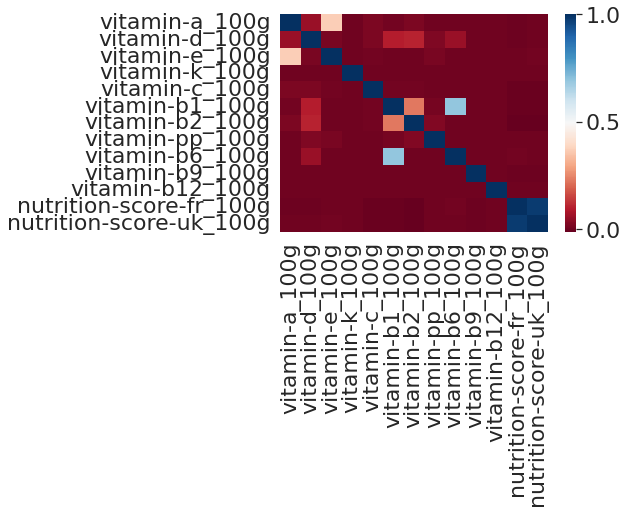

In [ ]:
corr_matrix = vitamin_df.corr()
sns.heatmap(corr_matrix, cmap = 'RdBu',
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

From the above correlation matrix, we can see that there's a clear correlation between French nutrition scores and UK nutrition scores, which is as expected. Another minor finding is that vitamin-b6 and vitamin-b1 has some corrlations. However, to our surprise, there is no clear correlation between any vitamins and nutrition scores.

Next we created another correlation matrix with other categories.

<AxesSubplot: >

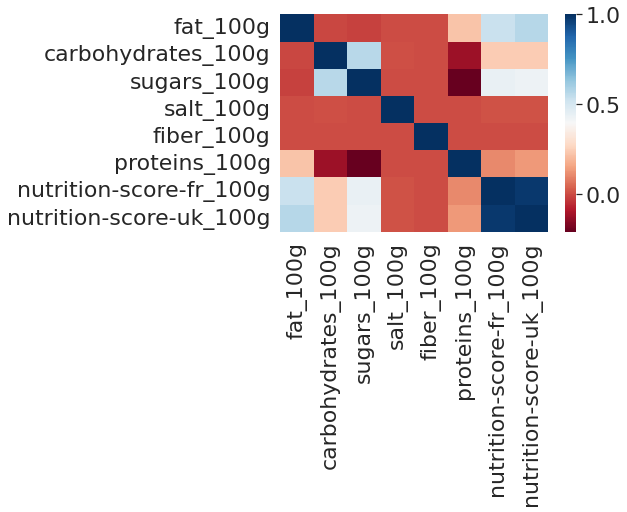

In [ ]:
corr_matrix = common_df.corr()
sns.heatmap(corr_matrix, cmap = 'RdBu',
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

From the correlation matrix above, we can see that multiple categories shows correlations to the nutrition scores. Sugar and carbonhydrades has correlation, which is expected. Among them, fat and sugar have the most clear correlation to the nutrition score.

We further explore the relationship of sugar, fat, and nutrition score.

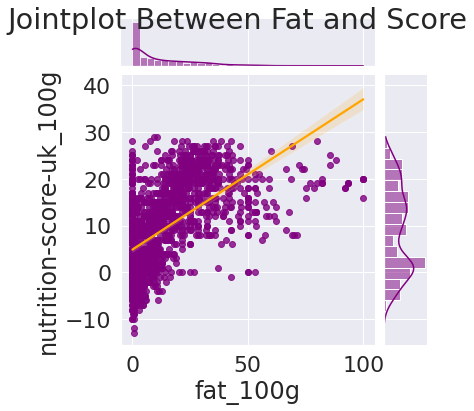

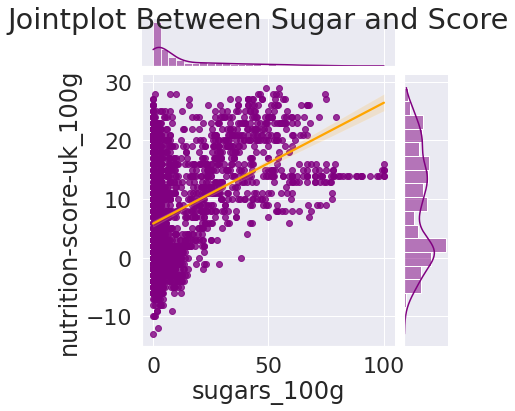

In [ ]:
# Explore relationship between fat and nutrition score
sample = df_food_clean.sample(n=2000, random_state = 1)
fat_score_df = sample[["fat_100g", "nutrition-score-uk_100g"]]

sns.jointplot(data = fat_score_df, x = "fat_100g", y = "nutrition-score-uk_100g", kind = "reg", color = "purple", joint_kws = {"line_kws": {"color": "orange"}});
plt.suptitle("Jointplot Between Fat and Score");
plt.subplots_adjust(top = 0.95);

# Explore relationship between sugar and nutrition score
sugars_score_df = sample[["sugars_100g", "nutrition-score-uk_100g"]]

sns.jointplot(data = sugars_score_df, x = "sugars_100g", y = "nutrition-score-uk_100g", kind = "reg", color = "purple", joint_kws = {"line_kws": {"color": "orange"}});
plt.suptitle("Jointplot Between Sugar and Score");
plt.subplots_adjust(top = 0.95);

From the above two graphs, we can see that in those 2000 random selected sample of products, most products have zero fat and sugar. Also, both two orange linear regression line suggest positive correlation between fat and nutrition score, sugar and nutrition score. Steeper line in graph "Jointplot Between Fat and Score" indicates stronger correlation between fat and nutrition. which is not exactly what we expected. We were thinking about a more complexed relationship, like nutrition score goes down when there's too much fat. But apparently the more fat and sugar, the higher the score. Later in the model we will definitely include sugar and fat since they have a clear relationship with the nutrition score.

We further studied whether nutrition scores are based on the origins of the food.

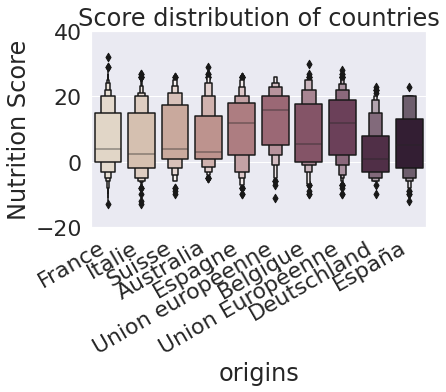

In [ ]:
origin_df = df_food_clean[['origins',"nutrition-score-uk_100g"]]
top_origins = origin_df.groupby(['origins']).count().reset_index().sort_values(by = 'nutrition-score-uk_100g',ascending = False)[:10]['origins'].tolist()
origin_df = df_food_clean.loc[(df_food_clean['origins'].isin(top_origins))]
origin_bp = sns.boxenplot(x='origins',y='nutrition-score-uk_100g',data=origin_df,
                            palette="ch:.25")

origin_bp.get_figure().autofmt_xdate()
origin_bp.set_ylabel('Nutrition Score')
origin_bp.set_title('Score distribution of countries')
origin_bp.set_ylim(-20,40)
plt.show()

We chose the top 10 origns with the most entries in our data. From the graph, we can see that although EU has a higher nutrition score in general and Dutch has a lower nutrition socre, there is no significant difference between the nutrition scores of each orign places. The IQR boxes all have similar ranges and few outliers.

# Models

###Regression Model

#### Linear Regression Model


In this section, we perform a simple Linear Regression on the joined data to predicte the nutrition score based on the given nutrient. After selecting the nutrients as features and the `nutrition-score-uk_100g` column as the label, we split the data into a training and testing sets with a size of 80% and 20%, respectively. We set `seed = 42` as we usually do for sklearn model.

In [ ]:
# Train, Test data set up
seed = 42
features = df_food_clean[['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g',
       'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g',
       'vitamin-b12_100g','fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g',
       'fiber_100g', 'proteins_100g']]
label = df_food_clean['nutrition-score-uk_100g']
x_train, x_test, y_train, y_test = train_test_split(features,label,random_state=seed,test_size=0.2)

We choose linear regression model as baseline to train our models because after previous EDA, we believe that there might exist a linear relationship between nutrient and nutrition score. We choose R2 score to measure our models' performance since R2 score can tell us how well the data fit the regression model.

In [ ]:
# Linear Regression
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
score = r2_score(y_test,y_pred)
print('R2 score for Linear Regression is:',score)

R2 score for Linear Regression is: 0.5438561869729246


R2 score is 54.4%, which tells us that about 54.4% of the dependent data can be explained by the model, so we can see that linear regression is not a good model for predicting nutrition score in the given dataset.

One possible reason is that some varibales are correlated with each other, as we saw earlier in the heatmap that sugar and carbonhydrades has correlation. One reasonable solution to address this issue is to apply regularization to the model. That is, using Lasso Regression (L1 Regularization) and Ridge Regreession (L2 Regularization) models to predict. Basically, these two models will try to eliminate less important features in the dataset by introducing a penalty factor.

#### Lasso Regression Model


In [ ]:
# Lasso Regression
reg_lasso = Lasso()
reg_lasso.fit(x_train,y_train)
y_pred = reg_lasso.predict(x_test)
lasso_score = r2_score(y_test,y_pred)
print('R2 score for Lasso Regression is:',lasso_score)

R2 score for Lasso Regression is: 0.5456293096713312


#### Ridge Regression Model


In [ ]:
# Ridge Regression
reg_ridge = make_pipeline(StandardScaler(with_mean=False), Ridge()) # fitting Ridge model with normalization
reg_ridge.fit(x_train,y_train)
y_pred = reg_ridge.predict(x_test)
ridge_score = r2_score(y_test,y_pred)
print('R2 score for Ridge Regression is:',ridge_score)

R2 score for Ridge Regression is: 0.5438557569122371


From above results, we can see that neither lasso regularization nor ridge regulatization improve the model. We might consider use PCA to reduce dimension to see how the model performs.

###Classification Model


####Classification Model in Sklearn

Instead of predicting detailed nutrition score for products, we'd like to divide them into categories. There are two reasonable way to achieve this. One is divide them into two categories: `good (1)` or `bad (0)` based on the mean. Other one is divide them into three categories : `bad (0)`, `normal (1)`, and `good (2)`, based on their nutrition scores. Assigning numerical number to them is for the purpose of using classification model. As before, `features` is selected nutrients, ratio of train and test is `80:20`, `seed = 42`, while `label` here is the transformed nutrition score (a series of 0,1,2).

In [ ]:
# Train, Test data set up
seed = 42
scoremean = df_food_clean['nutrition-score-uk_100g'].mean()
def grade_divide1(x):
  if x<scoremean:
    result = 0 # bad product
  else:
    result = 1 # good product
  return result

grade = (df_food_clean['nutrition-score-uk_100g'].max() - df_food_clean['nutrition-score-uk_100g'].min())/3
def grade_divide2(x):
  if x<=grade:
    result = 0 # bad product
  elif (x<=2*grade) & (x>grade):
    result = 1 # normal product
  else:
    result = 2 # good product
  return result
features = df_food_clean[['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g',
       'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g',
       'vitamin-b12_100g','fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g',
       'fiber_100g', 'proteins_100g']]
label1 = df_food_clean['nutrition-score-uk_100g'].apply(lambda x:grade_divide1(x))
label2 = df_food_clean['nutrition-score-uk_100g'].apply(lambda x:grade_divide2(x))

Let's check whether these two divide methods produce balanced classes.

In [ ]:
# Divide Method 1: mean
print('Divide Method 1 class balance')
print(label1.value_counts())
# Divide Method 2: nutrition score
print('Divide Method 2 class balance')
print(label2.value_counts())

Divide Method 1 class balance
1    132045
0    122811
Name: nutrition-score-uk_100g, dtype: int64
Divide Method 2 class balance
0    206181
1     48668
2         7
Name: nutrition-score-uk_100g, dtype: int64


Using mean to divide them into two categories is more balanced, so we will use this method to encode our labels.

In [ ]:
label = label1
x_train, x_test, y_train, y_test = train_test_split(features,label,random_state=seed,test_size=0.2)

#####Logistic Regression
We choose logistic regression model as baseline to improve our classification model.

In [ ]:
# LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
y_pred = log_reg.predict(x_test)
log_reg_score = log_reg.score(x_test,y_test)
print('Accuracy for Logistic Regression is:',log_reg_score)

Accuracy for Logistic Regression is: 0.9113238640822412


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can see that logistic regression model has a high accuracy. Let's try PCA to see how the model performs.

##### Logistic Regression with PCA
PCA will linearly transforming the data into a new coordinate system where most of the variation in the data can be described with fewer dimensions than the initial data. We set the threshold to be 80%. That is, we will choose `n` components that can explain 80% of the variance.

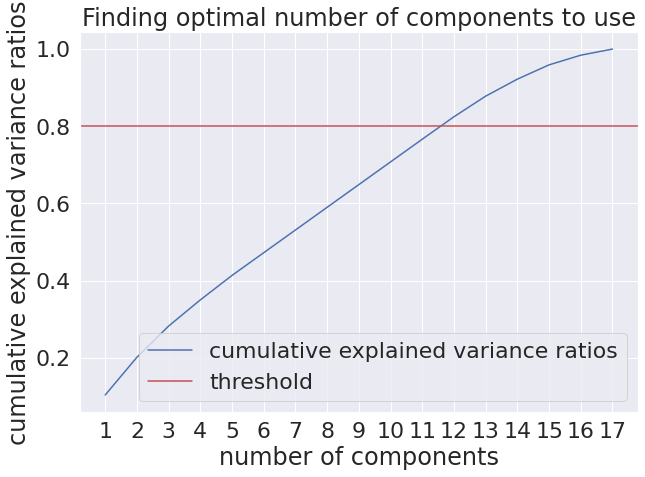

In [ ]:
# PCA
n = 17

features = StandardScaler().fit_transform(features)
pca = PCA(n_components=n)
features_pca = pca.fit_transform(features)

explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(n),cum_evr,label='cumulative explained variance ratios')
plt.axhline(y=0.8*np.sum(explained_variance_ratios), color='r', linestyle='-',label='threshold')
plt.xticks(np.arange(n),np.arange(1,n+1))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratios')
plt.legend(loc='best')
plt.title('Finding optimal number of components to use')
plt.show()

It's clear to see that the optimal number of components for PCA to use is 12, so we set `n = 12`, and transform data with this paramater.

In [ ]:
n = 12
scale = StandardScaler()
scale.fit(x_train)
x_train_sc = scale.transform(x_train)
x_test_sc = scale.transform(x_test)
pca = PCA(n_components=n)
x_train_pca = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)

# Logistic Regression with PCA
log_reg_pca = LogisticRegression()
log_reg_pca.fit(x_train_pca,y_train)
y_pred = log_reg_pca.predict(x_test_pca)
log_reg_pca_score = log_reg_pca.score(x_test_pca,y_test)
print('Accuracy for Logistic Regression with PCA is:',log_reg_pca_score)

Accuracy for Logistic Regression with PCA is: 0.803166444322373


Apply PCA doesn't improve the model, which implies that there is no collinearity between the features that will hurt the performance of this model.

####Classification Model in Pytorch
In this section, we will use some deep learning classification models in Pytorch to predict products' categories. We prepare our data as the same as we did earlier in classification model in Sklearn.

In [ ]:
features = df_food_clean[['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g',
       'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g',
       'vitamin-b12_100g','fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g',
       'fiber_100g', 'proteins_100g']]
label = df_food_clean['nutrition-score-uk_100g'].apply(lambda x:grade_divide1(x))
combined_df = pd.concat([features,label],axis=1)

In [ ]:
train_df = combined_df.sample(frac=0.8)
test_df = combined_df.drop(train_df.index)

train_label = train_df['nutrition-score-uk_100g'].values
train_features = train_df.drop('nutrition-score-uk_100g',axis=1).values
train = torch.utils.data.TensorDataset(torch.Tensor(train_features), torch.Tensor(np.array(train_label)))
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

test_label = test_df['nutrition-score-uk_100g'].values
test_features = test_df.drop('nutrition-score-uk_100g',axis=1).values
test = torch.utils.data.TensorDataset(torch.Tensor(test_features), torch.Tensor(np.array(test_label)))
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

#####Logistic Regression
We will start with a simple logistic regression model to perform prediction. Basically, it contains one linear layer and an activation function, `sigmoid`.

In [ ]:
class LogisticRegression(nn.Module):
     def __init__(self):
         super().__init__()
         self.linear = nn.Linear(17, 2) # 17 = number of features, 2 = number of classes we try to predict
         self.sig = nn.Sigmoid()
     def forward(self, x):
         outputs = self.sig(self.linear(x))
         return outputs

To measure the loss during each epoch, we choose `CrossEntropyLoss` as loss criterion, `Adam` as optimizer, calling `optimizer.zero_grad()` to zero out the gradients, `backward()` to compute the gradient by backpropagation, and `optimizer.step()` to update the weight using the gradients from back propagation by learning step.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logreg = LogisticRegression().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(logreg.parameters(), lr=1e-4)
epoch = 20

loss_logreg = []
acc_logreg = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor)
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = logreg(inputs)
      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_logreg.append(accuracy)
  loss_logreg.append(running_loss/len(train_loader))

In [ ]:
total = 0
correct = 0
with torch.no_grad():
  for inputs, labels in test_loader:
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = logreg(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_acc_logreg = 100 * correct / total

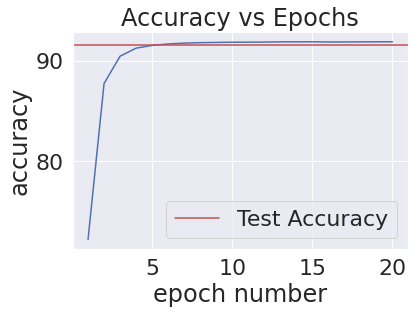

In [ ]:
x = np.arange(1,21)
y = acc_logreg
plt.plot(x,y)
plt.title('Accuracy vs Epochs')
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.axhline(y=test_acc_logreg, color='r', linestyle='-',label='Test Accuracy')
plt.legend(loc='best')
plt.show()

We can see that roughly after 5 epochs, as the number of epoch increases, the train accuracy doesn't change, which implies that higher train accuracy is hard to achieve even though we increase the number of epoches. Although it's a high accuracy for a model, we can try to improve its performance by adding more layers. Accuracy is quite similiar for train and test data, which suggests this is a good fit.

#####Feedforward Neural Networks
Since logistic regression still has room for improving, we choose `Feedforward Neural Networks (FNN)` as our model. Compared to the above model, FNN has hidden layers to identify features from the input data and use them to correlate between a given input and the correct output. Therefore, FNN should perform better than the above logistic regression model theoretically.

In [ ]:
class FNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(17,60)
    self.relu = nn.ReLU() # We choose ReLU over Sigmoid as our activation function because it can reduce likelihood of the gradient to vanish, and generate sparse representations
    self.fc2 = nn.Linear(60,2)

  def forward(self, x):
    outputs = self.fc2(self.relu(self.fc1(x)))
    return outputs

In [ ]:
fnn = FNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-4)
epoch = 20

acc_fnn = []
loss_fnn = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = fnn(inputs)
    optimizer.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_fnn.append(accuracy)
  loss_fnn.append(running_loss/len(train_loader))

In [ ]:
total = 0
correct = 0
with torch.no_grad():
  for inputs, labels in test_loader:
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = fnn(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_acc_fnn = 100 * correct / total

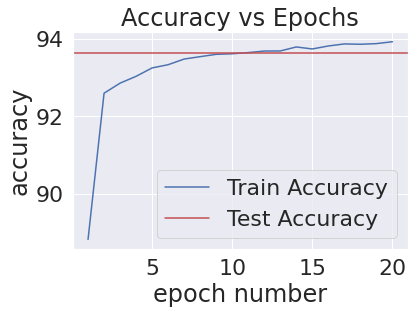

In [ ]:
x = np.arange(1,21)
y = acc_fnn
plt.plot(x,y,label='Train Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.axhline(y=test_acc_fnn, color='r', linestyle='-',label='Test Accuracy')
plt.legend(loc='best')
plt.show()

Indeed, FNN model performs better than logistic regression model within the same number of epochs. Also, the train accuracy tends to keep increasing as the number of epochs increases, which implies higher train accuracy is achievable if we increases the number of epochs. Similiar accuracy in train and test suggests FNN is a good fit.

#Conclusion

##EDA


We gained a lot more insight about the dataset by performing EDA. It made our modeling and data processing easier.

We confirmed the similiarities between France nutrition scores and UK nutrition scores by doing statistical analysis on the 2 columns. We further checked the average UK and France scores for top brands and the result matches with our previous conclusion.

By ranking the brands based on score, we noticed that multiple top ranking brandds are chocolate-related companies. We further explored the ingredients of chocolate which prepared our later analysis.

We then did analysis of common ingredients among food orginate from US and France. While sugar and salt are very common ingredients among both US and France foods, more food from US tends to contain more oil than France, which could be a potential cause of the higher diabetes rate for the US. We further narrow down and explored the ingreidents composition of different brands among the 2 countries, but we didn't find any significant difference among different brands.

We then explored additives in foods since additives have always been controversial. We plotted the number of additives in all foods and the histogram is heavily right skewed, meaning that most foods have around 0 additives. We plotted the nutrition score based on the number of additives, and discovered that the graph has a roughly positive slope, meaning that the more additives, the higher the nutrition score. However, this could be an example of confounding factor, since food with a lot of additives tends to have a lot of other cruicial ingredients, such as sugar and fat. Furthermore, the data is very imbalanced, as we have more than 70% of the foods have less than 4 additives. Therefore, we cannot conclude the relationship between additives and nutrition scores.

We then created multiple correlation matrix to detect any possible correlations between columns. To our surprise, all the vitamins shows no correlation with nutrition scores, when sugar and fat shows fairly strong correlation with the nutrition scores. We further explored the relationship between sugar, fat, and nutrition score. Based on the two jointplot, we can clearly see that there's a positive correlation between sugar and score, fat and score. While a lot of the samples have 0 fat and sugar, once the amount of fat/sugar passed 50g, the nutrition score is always above 0 and increasing. We can confidently say that there is a positive correlation between fat, sugar and nutrion score.

We created boxplots to explore the nutrition scores of different countries, but no clear relation is shown based on the graphs.


##Modeling

In our modeling process, we aim to find the relationship between nutrient and food score. EDA has informed us that UK scoring system and France scoring system is quite similar. Therefore, we decree UK scoring as our label. To predict nutrient scoring, we tried linear regression models with different regularization method used. We found that the performance has not improved a lot with regularization. All of the linear regression method reaches approximately 50% accuracy. Since this is not a binary question, this result for linear regression is moderate.

The problem with score prediction is that it is hard to judge the correctness of the result without number rounding and ceiling. As our second step, we modified the label to turn the problem into a classification model. Rather than trying to predict the very food score, we tried two ways of dividing food score: one is dividing them into two categories: `good (1)` or `bad (0)` based on the mean. The other one is divide them into three categories : `bad (0)`, `normal (1)`, and `good (2)`, based on their nutrition scores. The reason why this dividing is reasonable is that scoring inherently gives people impression on each kind of food product. People could feel large difference when score is changed from 1 to 2 while would not get shocked to much when score varies from 1.5 to 1.6.

Then we turn to Logistic Regression model with the feature changes to `good (1)` or `bad (0)`. We witnessed a test accuracy of approximately 90% using Logistic Regression. To handle the potential collinearity within these features seen from previous Nutrient Analysis in EDA, we used PCA to select first several components that can best represent dataset. We chose 12 out of 17 features as our transformed features with 80% cumulative explained variance ratios reached. But PCA does not help improve model performance. The accuracy drops to 80%. This probably means that there is no strong collinearity among features.

Finally, we tried several model using Pytorch. We set up a small scalse Feedforward Neural Network to predict whether a given food is `good (1)` or `bad (0)` based on its nutrient. FNN has slightly improved the performance reaching 93.5% test accuracy.

##Potential Next Steps



We could collect more data to train and test our model. Since the models are showing promising results, we want to further test it's accuracy with more datasets.

We could try to train the neural network with different inputs than this time since every teammates suggested to use different parameters and we didn't want to put all of them in, so we chose this set. We want to test other possible input sets and compare the difference in results.

We should try to do explore which inputs are affecting the result the most. We want to know what ingredients have the most impact on nutrition score, and we believe by studying the weights of the neural network we should be able to find out. We could also conduct ablation studies to further test the impact of each input.

We should conduct more sophisticated fine tuning procedures in order to decide the optimal hyper parameters for our model. By testing multiple hyper parameters, we should be able to discover the optimal value for things like model depth, learning rate, neuron count, etc. However, this will take longer time since we have to test numerous parameters.

We should further study our model and try to understand the result better. We should test the model with more metrics. For example, we could print out the confusion matrix, ROC curve and AUC value, etc. With more outputs about the result like precision and recall, we should be able to have a better understanding of the performance of the neural network.